Epoch 1/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4861 - val_loss: 2.3301
Epoch 2/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2574 - val_loss: 2.3362
Epoch 3/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2030 - val_loss: 2.3607
Epoch 4/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1600 - val_loss: 2.5516
Epoch 5/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1377 - val_loss: 2.7696
Epoch 6/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1352 - val_loss: 3.0580
Epoch 7/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1323 - val_loss: 3.3106
Epoch 8/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1297 - val_loss: 3.5803
Epoch 9/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1282 - val_loss: 3.8258
Epoch 10/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1273 - val_loss: 4.0714
Epoch 11/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1261 - val_loss: 4.3427
Epoch 12/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

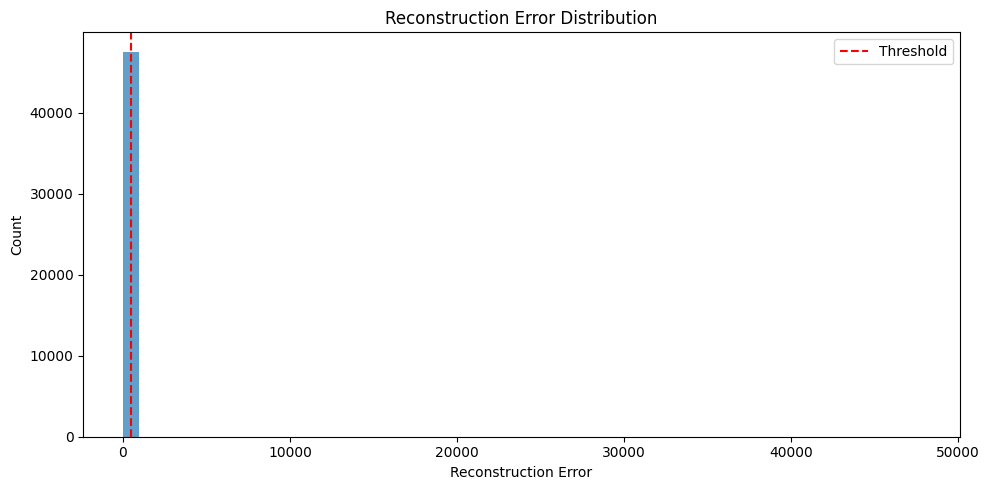

✅ Model saved as 'vehicle_health_autoencoder.keras'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Step 1: Load CSV safely
# -------------------------------
data = pd.read_csv(r'C:/Kumidhini/Vehicle_Health/combined_output.csv', low_memory=False)

# -------------------------------
# Step 2: Select only numeric features
# -------------------------------
numeric_data = data.select_dtypes(include=[np.number])

# Optional: Drop columns with too many missing values
numeric_data = numeric_data.dropna(axis=1, thresh=0.8 * len(numeric_data))

# Fill remaining missing values
numeric_data = numeric_data.fillna(numeric_data.mean())

# -------------------------------
# Step 3: Normalize the data
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_data)

# -------------------------------
# Step 4: Autoencoder Architecture
# -------------------------------
input_dim = X_scaled.shape[1]
encoding_dim = 12

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(6, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# -------------------------------
# Step 5: Train the Autoencoder
# -------------------------------
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=50,
                          batch_size=64,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

# -------------------------------
# Step 6: Calculate Reconstruction Error
# -------------------------------
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
print(f"Anomaly threshold: {threshold:.4f}")

# -------------------------------
# Step 7: Predict Anomalies
# -------------------------------
predicted_condition = np.where(reconstruction_error > threshold, 1, 0)

# Count healthy vs anomaly
unique, counts = np.unique(predicted_condition, return_counts=True)
print("Predicted condition distribution:", dict(zip(unique, counts)))

# -------------------------------
# Step 8: Plot Reconstruction Error
# -------------------------------
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Step 9: Save Model Prototype
# -------------------------------
autoencoder.save("vehicle_health_autoencoder.keras")
print("✅ Model saved as 'vehicle_health_autoencoder.keras'")
